# AI INTEGRATED CCTV SURVEILLANCE

<ol>
    <li> <h6>JAY</h6> </li>
    <li>  <h6>RAMA </h6></li>
    <li> <h6> HARIPRASAD </h6> </li>
    <li> <h6>SHREE</h6> </li>
</ol>

In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from twilio.rest import Client

# Twilio Intialization

In [3]:
#twilio initialization
acc_sid = "ACbf103ec883de3636b39a28a691623d0b"

auth_tkn ="ba95b855a431111a3d2bb19d2a6a6a46"

client = Client(acc_sid , auth_tkn)


And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

#### **<font style="color:rgb(134,19,348)">Step 1: Visualize the Data with its Labels</font>**


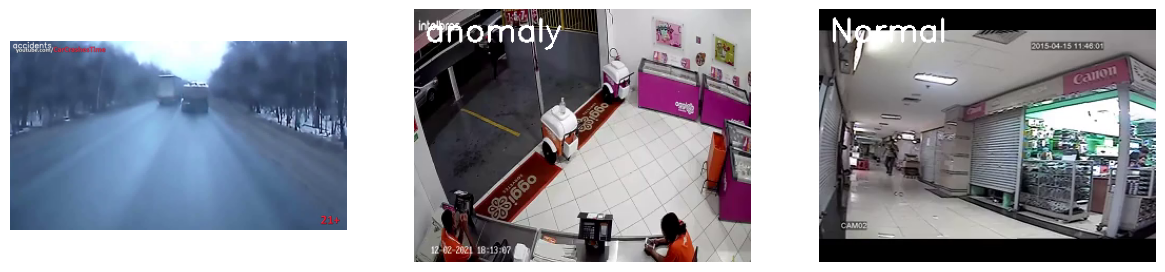

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('Dataset')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset.
# random_range = random.sample(range(len(all_classes_names)), 20)  -> selectes 20 categories randomly (0 to 49 is label for categories)
#shree->i have 3 class/categorie ['accidents', 'anomaly', 'Fire','Normal'] and i want all these categories so ..include all these categories
#             import random  
#             from random import sample 
#             # Prints list of random items of given length 
#             list1 = [1, 2, 3, 4, 5]  
#             print(sample(list1,3))  0/p->[2,5,1]  randomly selected

#shree <-

# Iterating through all the generated random values.
for counter, index in enumerate(range(len(all_classes_names)), 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'Dataset/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'Dataset/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 100, 100

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 50

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "Dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['accidents', 'anomaly','Normal']

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames. 

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: accidents


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [9]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels,3)

In [10]:
one_hot_encoded_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [11]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video. 


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>


You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot. 

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [12]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [13]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

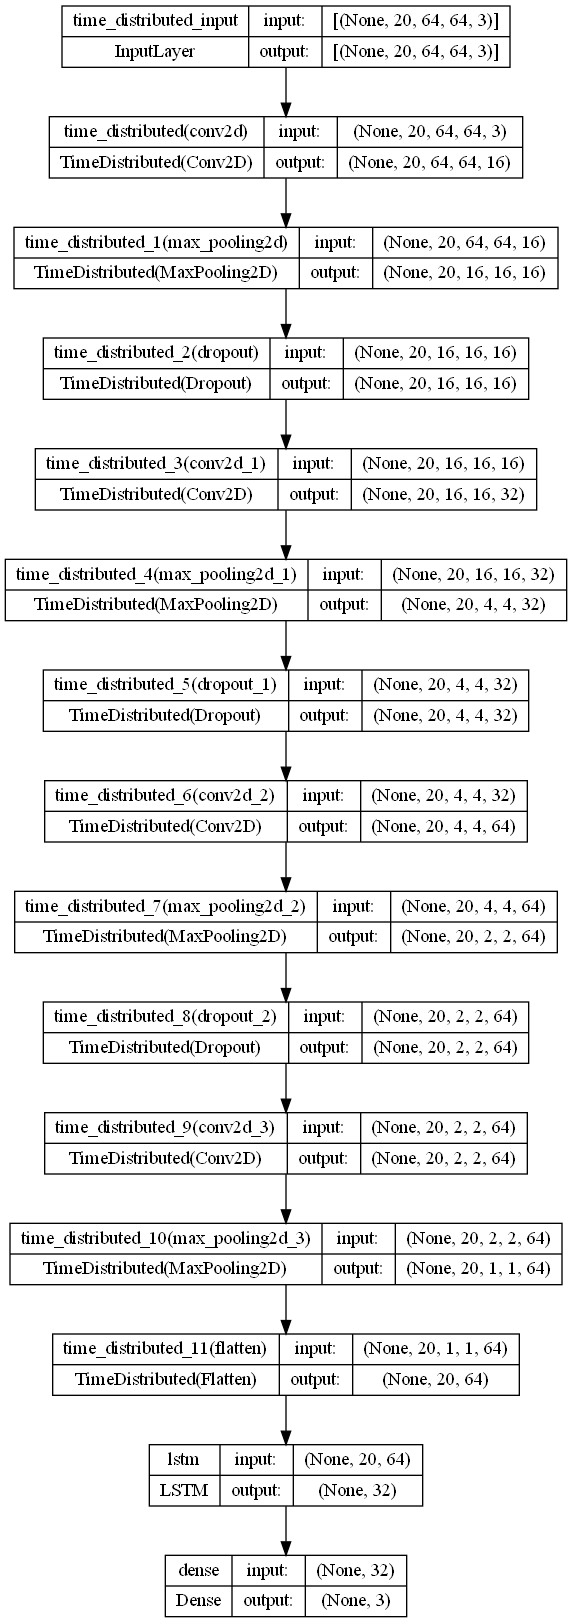

In [14]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [15]:
# # Create an Instance of Early Stopping Callback.
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# # Compile the model and specify loss function, optimizer and metrics to the model.
# LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# # Start training the model.
# LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4 ,
#                                              shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


#"batch processing" or "chunk processing," 


# Define the chunk size (e.g., 1 GB)
chunk_size = 1024 * 1024 * 50  # 50mb 

# Determine the total number of samples
total_samples = features_train.shape[0]

# Determine the number of chunks needed
num_chunks = total_samples // chunk_size + 1

# Define Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Compile the model
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Iterate over chunks
for i in range(num_chunks):
    # Calculate start and end indices for the current chunk
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, total_samples)

    # Load the chunk of data
    features_chunk = features_train[start_idx:end_idx]
    labels_chunk = labels_train[start_idx:end_idx]

    # Train the model on the current chunk
    print(f"Training chunk {i+1}/{num_chunks}")
    LRCN_model.fit(x=features_chunk, y=labels_chunk, epochs=50, batch_size=1,shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

    # Clear memory after each chunk
    del features_chunk
    del labels_chunk
    tf.keras.backend.clear_session()   # Clear TensorFlow session to release memory



Training chunk 1/1
Epoch 1/50
675/675 [==============================] - 33s 44ms/step - loss: 0.6678 - accuracy: 0.7111 - val_loss: 0.3976 - val_accuracy: 0.8698
Epoch 2/50
675/675 [==============================] - 29s 43ms/step - loss: 0.3772 - accuracy: 0.8637 - val_loss: 0.3115 - val_accuracy: 0.9112
Epoch 3/50
675/675 [==============================] - 29s 43ms/step - loss: 0.3526 - accuracy: 0.8741 - val_loss: 0.3234 - val_accuracy: 0.9112
Epoch 4/50
675/675 [==============================] - 29s 43ms/step - loss: 0.2724 - accuracy: 0.8963 - val_loss: 0.2825 - val_accuracy: 0.8817
Epoch 5/50
675/675 [==============================] - 29s 43ms/step - loss: 0.2607 - accuracy: 0.9007 - val_loss: 0.3054 - val_accuracy: 0.8994
Epoch 6/50
675/675 [==============================] - 29s 43ms/step - loss: 0.2574 - accuracy: 0.9052 - val_loss: 0.3507 - val_accuracy: 0.8935
Epoch 7/50
675/675 [==============================] - 29s 43ms/step - loss: 0.2135 - accuracy: 0.9141 - val_loss: 0.2

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [16]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 [==============================] - 1s 106ms/step - loss: 0.1578 - accuracy: 0.9198


In [17]:
features_test

array([[[[[0.2627451 , 0.25098039, 0.24705882],
          [0.37254902, 0.36078431, 0.36862745],
          [0.28235294, 0.2627451 , 0.26666667],
          ...,
          [0.30588235, 0.33333333, 0.3372549 ],
          [0.30588235, 0.31372549, 0.32156863],
          [0.20784314, 0.20392157, 0.21176471]],

         [[0.43921569, 0.42745098, 0.41568627],
          [0.61176471, 0.59215686, 0.61176471],
          [0.65490196, 0.64705882, 0.65490196],
          ...,
          [0.52156863, 0.55686275, 0.56078431],
          [0.49803922, 0.51372549, 0.52156863],
          [0.34509804, 0.34901961, 0.35686275]],

         [[0.64705882, 0.62745098, 0.63529412],
          [0.96078431, 0.95294118, 0.95294118],
          [0.95686275, 0.97254902, 0.97647059],
          ...,
          [0.50588235, 0.54901961, 0.55294118],
          [0.50980392, 0.53333333, 0.54117647],
          [0.35686275, 0.37647059, 0.38039216]],

         ...,

         [[0.08235294, 0.09411765, 0.09411765],
          [0.12941176,

In [18]:
labels_test

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [18]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [1]:
#to Load the model
from tensorflow.keras.models import load_model

# Specify the path to the saved model file
saved_model_path = r"D:/DEEP_LEARNING/FINAL_YEAR_PROJECT/Human Activity Recognition using TensorFlow (CNN + LSTM) Code/LRCN_model___Date_Time_2024_05_23__09_47_26___Loss_0.15782125294208527___Accuracy_0.9198113083839417.h5"

# Load the model
LRCN_model= load_model(saved_model_path)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


In [2]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [3]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

NameError: name 'LRCN_model_training_history' is not defined

In [4]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

NameError: name 'LRCN_model_training_history' is not defined

### **<font style="color:rgb(134,19,348)">Create a Function To Perform a Single Prediction on Videos</font>**


Now let's create a function that will perform a single prediction for the complete videos. We will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the `LRCN` model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.  

In [13]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
    
    #Twilio phone redirection...
    if predicted_class_name == 'anomaly':
        print('CALLING THE POLICE.......................')
#         call = client.calls.create(twiml = '<Response><Say>Alert,alert,alert Anomaly detected at Maratha Mandal Engineering college</Say></Response>',to ='+919663659354',from_= '+12076001739')
            
    elif predicted_class_name == "accidents":
        print('CALLING THE POLICE AND AMBULANCE..........................')
#         call = client.calls.create(twiml = '<Response><Say>Alert,alert,alert Accident occured near Maratha Mandal Engineering college please send the ambulance and get the police</Say></Response>',to ='+919663659354',from_= '+12076001739')
        
    else:
        print('NORMAL SITUATION.......NO NEED ANY KIND OF ACTION')
    
    
        
    # Release the VideoCapture object. 
    video_reader.release()

In [16]:
input_video_file_path = "D:/DEEP_LEARNING/FINAL_YEAR_PROJECT/Human Activity Recognition using TensorFlow (CNN + LSTM) Code/Dataset/accidents/001465.mp4"
# Perform Single Prediction on the Test Video.
predict_single_action(r"D:\DEEP_LEARNING\FINAL_YEAR_PROJECT\Human Activity Recognition using TensorFlow (CNN + LSTM) Code\Dataset\accidents\001465.mp4", SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 62ms/step
Action Predicted: accidents
Confidence: 0.997288703918457
CALLING THE POLICE AND AMBULANCE..........................
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Try ConvoLstm once,,,to get better one..

# Reading Frames from web-cam in REAL-TIME

In [8]:
#loading the saved model
#to Load the model
from tensorflow.keras.models import load_model

# Specify the path to the saved model file
saved_model_path = r"D:/DEEP_LEARNING/FINAL_YEAR_PROJECT/Human Activity Recognition using TensorFlow (CNN + LSTM) Code/LRCN_model___Date_Time_2024_05_08__09_01_59___Loss_1.2379612922668457___Accuracy_0.3684210479259491.h5"

# Load the model
LRCN_model= load_model(saved_model_path)

In [9]:
# import cv2
# import os
# from datetime import datetime
# # Initialize the webcam
# cap = cv2.VideoCapture(0)

# # Check if the webcam is opened correctly
# if not cap.isOpened():
#     print("Error: Could not open webcam.")
#     exit()

# # Define the codec and create VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# output_folder = 'captured_videos'
# os.makedirs(output_folder, exist_ok=True)
# video_name = os.path.join(output_folder, f"video_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.avi")
# out = cv2.VideoWriter(video_name, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# # Variables to keep track of time
# start_time = datetime.now()
# interval = 20  # in seconds

# # Loop to capture images
# while True:
#     # Capture frame-by-frame
#     ret, frame = cap.read()

#     # Write the frame to the output video
#     out.write(frame)

#     # Display the captured frame
#     cv2.imshow('Webcam', frame)

#     # Check if 20 seconds have elapsed
#     elapsed_time = (datetime.now() - start_time).total_seconds()
#     if elapsed_time >= interval:
#         # Save the video and start a new one
#         out.release()
#         video_name = os.path.join(output_folder, f"video_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.avi")
#         out = cv2.VideoWriter(video_name, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))
#         start_time = datetime.now()

#     # Wait for 'q' key to quit the program
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release the webcam, release the output video, and close all OpenCV windows
# cap.release()
# out.release()
# cv2.destroyAllWindows()



#what is CODEC?
# A codec is a software component that compresses and decompresses digital media files, such as audio and video. The term "codec" is derived from a combination of "coder" and "decoder."
# Codecs are essential for reducing the size of digital media files, allowing them to be efficiently stored, transmitted, and played back. When you record a video or capture audio, the codec compresses the data to reduce its size. When you play back or edit the media, the codec decompresses the data so it can be viewed or heard.
# Different codecs use different algorithms to compress and decompress media files. Common video codecs include H.264, H.265 (also known as HEVC), MPEG-4, and VP9. Common audio codecs include MP3, AAC, and FLAC. The choice of codec can significantly impact the quality and file size of the media

#what is XVID?
# Xvid is a video codec library following the MPEG-4 video coding standard, specifically MPEG-4 Part 2 Advanced Simple Profile (ASP). It aims to provide high compression efficiency and good video quality, making it suitable for various video applications.
# Xvid is an open-source project, meaning its source code is freely available for anyone to use and modify under the GNU General Public License (GPL). It's widely used for video encoding and decoding in applications such as video streaming, video conferencing, digital video distribution, and more.
# One of the reasons for Xvid's popularity is its ability to achieve high compression ratios without significantly sacrificing video quality. This makes it suitable for compressing large video files into smaller sizes for storage or transmission over networks while maintaining reasonable visual fidelity.
# In the context of the provided Python code, Xvid is used as the codec for compressing the video frames before writing them to the output file. This allows the program to create compressed video files (.avi) with relatively small sizes while maintaining good quality.

# If you're observing videos with a duration of approximately 30 seconds, there could be factors affecting the frame rate or the timing of the video segments. These could include processing delays, system performance, or other factors. To accurately determine the duration of each video, you may want to inspect the properties of the video files or measure the actual duration using a video player or analysis tool.

In [25]:
#Logic For real time capturing
import cv2
import os
from datetime import datetime, timedelta

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_folder = 'captured_videos'
os.makedirs(output_folder, exist_ok=True)

# Variables for time tracking
start_time = datetime.now()
interval_capture = 20  # Interval for capturing video (in seconds)
lifespan = 60  # Lifespan of each video (in seconds)

# Loop to capture images
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Display the captured frame
    cv2.imshow('Webcam', frame)

    # Check if the interval for capturing video has elapsed
    elapsed_capture_time = (datetime.now() - start_time).total_seconds()
    if elapsed_capture_time >= interval_capture:
        # Save the video
        video_name = os.path.join(output_folder, f"video_{start_time.strftime('%Y-%m-%d_%H-%M-%S')}.avi")
        out = cv2.VideoWriter(video_name, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))
        capture_start_time = datetime.now()
        while (datetime.now() - capture_start_time).total_seconds() < interval_capture:
            ret, frame = cap.read()
            out.write(frame)
        out.release()
        start_time = datetime.now()

    # Delete videos older than the lifespan
    current_time = datetime.now()
    videos = os.listdir(output_folder)
    for video in videos:
        video_path = os.path.join(output_folder, video)
        creation_time = datetime.fromtimestamp(os.path.getctime(video_path))
        if (current_time - creation_time).total_seconds() > lifespan:
            os.remove(video_path)

    # Wait for 'q' key to quit the program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


In [ ]:

from datetime import datetime, timedelta

def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
    
    #Twilio phone redirection...
    if predicted_class_name == 'anomaly':
        print('CALLING THE POLICE')
        call = client.calls.create(twiml = '<Response><Say>Alert,alert,alert Anomaly detected at Maratha Mandal Engineering college</Say></Response>',to ='+919663659354',from_= '+12076001739')
            
    elif predicted_class_name == "accidents":
        print('CALLING THE POLICE AND AMBULANCE')
        call = client.calls.create(twiml = '<Response><Say>Alert,alert,alert Accident occured near Maratha Mandal Engineering college please send the ambulance and get the police</Say></Response>',to ='+919663659354',from_= '+12076001739')
        
    else:
        print('NORMAL SITUATION.......NO NEED ANY KIND OF ACTION')
    # Release the VideoCapture object. 
    video_reader.release()

def capture_and_recognize_videos():
    # Initialize the webcam
    cap = cv2.VideoCapture(0)

    # Check if the webcam is opened correctly
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        exit()

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    output_folder = 'captured_videos'
    os.makedirs(output_folder, exist_ok=True)

    # Variables for time tracking
    start_time = datetime.now()
    interval_capture = 10  # Interval for capturing video (in seconds)
    lifespan = 60  # Lifespan of each video (in seconds)

    # Loop to capture images
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Display the captured frame
        cv2.imshow('Webcam', frame)

        # Check if the interval for capturing video has elapsed
        elapsed_capture_time = (datetime.now() - start_time).total_seconds()
        if elapsed_capture_time >= interval_capture:
            # Save the video
            video_name = os.path.join(output_folder, f"video_{start_time.strftime('%Y-%m-%d_%H-%M-%S')}.avi")
            out = cv2.VideoWriter(video_name, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))
            capture_start_time = datetime.now()
            while (datetime.now() - capture_start_time).total_seconds() < interval_capture:
                ret, frame = cap.read()
                out.write(frame)
            out.release()
            start_time = datetime.now()

            # Perform action recognition on the captured video
            predict_single_action(video_name, SEQUENCE_LENGTH)

            # Delete the video file after one minute
            delete_start_time = datetime.now()
            while (datetime.now() - delete_start_time).total_seconds() < lifespan:
                pass  # Wait for the lifespan to elapse
            os.remove(video_name)  # Delete the video file

        # Wait for 'q' key to quit the program
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

# Call the function to start capturing and recognizing videos
capture_and_recognize_videos()


1/1 [==============================] - 1s 691ms/step
Action Predicted: accidents
Confidence: 0.46831202507019043
